In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import collections
from collections import Counter
import networkx as nx
import seaborn as sns
from collections import Counter
from matplotlib.colors import DivergingNorm
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
from matplotlib.pyplot import figure
import seaborn as sns

In [2]:
#Upload raw seqs
clustering_spreadsheet = open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/2022/summer 2022/ppp_new_clusters_FINAL.csv').readlines()
#Remove header
clustering_spreadsheet = clustering_spreadsheet[1:]
#Known cluster peak seqs
cs_peaks = ['GACAGCCGAGAAATGAGTGGCCTAAATGGGAGAATGAGCT','GACTGCGCGTATGAGTGGCGGCTAAAGAGGAGAATGAGCG','ACGGGTGGGTAATCTAGTGTCCGCGGAATAGAACGAAACA','GGATGGTGCGAACTGAGTGGGCTAATTAGGAGAATGAGCG','GGAGGGTGACATCGTTGAGAGAGAATGGGGATATTGAACT','AAGCTCTCGCCAGCAAAAGAACAGACCGTCGAGGAAACGG','CAATGCTATCCTCGGGGAACGATTCTGCGGAATCCGACAT','GAATCTGGCGAACGATTAGTCCTAATTGAGAATTATAGTT','AAGTGATGAATTCCCTGCGGGCTACTTGTTAGAGCGGGCT','GTGTGTTACGAACCGTGGCGACTAAGCGGGAGGGTGAACT']
quality_cutoff = 0.9
#Upload + process previous rounds of selection
#(Upload raw seqs)
raw_seqs = []
for round in range(1,7):
    raw_seqs.append(open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/2022/spring 2022/ppp landscape/seqs/ppp-'+str(round)+'_S'+str(round)+'_L001_R2_001.fastq').readlines())

#(Filter by quality)
all_high_quality = []
unique_high_quality = []
for round in raw_seqs:
    high_quality = []
    seqs = round[1::4]
    qualities = round[3::4]
    acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
    for seq in range(len(qualities)):
        overlap=0
        for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
            overlap+=qualities[seq].count(char)
        if overlap/len(qualities[1])>quality_cutoff:
            high_quality.append(seqs[seq].strip("\n"))
    print('High quality seqs r'+str(1+raw_seqs.index(round))+': '+str(len(high_quality)))
    all_high_quality.append(high_quality)
    unique_high_quality.append(list(set(high_quality)))
    print('Unique high quality seqs r'+str(1+raw_seqs.index(round))+': '+str(len(list(set(high_quality)))))
#(Trim seqs to randomized region)
all_trimmed_seqs = []
all_unique_trimmed_seqs = []
round = 1
for round in range(len(all_high_quality)):
    trimmed_seqs = []
    for seq in all_high_quality[round]:
        if 'ACTCACTGACACAGATCCACTCACGGACAGCG' in seq and 'CGCTGTCC' in seq:
            if len(seq[len('ACTCACTGACACAGATCCACTCACGGACAGCG')+seq.index('ACTCACTGACACAGATCCACTCACGGACAGCG'):seq.index('CGCTGTCC')]) == 40:
                trimmed_seqs.append(seq[len('ACTCACTGACACAGATCCACTCACGGACAGCG')+seq.index('ACTCACTGACACAGATCCACTCACGGACAGCG'):seq.index('CGCTGTCC')])
    all_trimmed_seqs.append(trimmed_seqs)
    all_unique_trimmed_seqs.append(list(set(trimmed_seqs)))
    

High quality seqs r1: 1793335
Unique high quality seqs r1: 1658322
High quality seqs r2: 1824368
Unique high quality seqs r2: 1617437
High quality seqs r3: 1238531
Unique high quality seqs r3: 301725
High quality seqs r4: 1959238
Unique high quality seqs r4: 136149
High quality seqs r5: 1553726
Unique high quality seqs r5: 115878
High quality seqs r6: 1515844
Unique high quality seqs r6: 126708


In [3]:
#Keep only seqs in cluster 3
cs3 = 'ACGGGTGGGTAATCTAGTGTCCGCGGAATAGAACGAAACA'
cs3_cluster_number = 0
cs3_counts = 0
for seq in clustering_spreadsheet:
    if cs3 in seq:
        cs3_cluster_number = seq.split(',')[-1].strip()
        cs3_counts = int(seq.split(',')[1].strip())
cs3_seqs_g100 = []   
cs3_seqs = []       
for seq in clustering_spreadsheet:
    #If in cluster 3
    if seq.split(',')[-1].strip() == cs3_cluster_number:
        cs3_seqs.append(seq.split(',')[0])
        #If reads > 100
        if int(seq.split(',')[1])>100:
            cs3_seqs_g100.append(seq.split(',')[0])

In [4]:
all_cs3_log_counts_per_round = []
for cs3_seq in cs3_seqs_g100:
    log_counts_per_round = []
    for round in range(len(all_trimmed_seqs)):
        log_counts_per_round.append(np.log(all_trimmed_seqs[round].count(cs3_seq)))
    all_cs3_log_counts_per_round.append(log_counts_per_round)

<ipython-input-4-894b482bb7b1>:5: RuntimeWarning: divide by zero encountered in log
  log_counts_per_round.append(np.log(all_trimmed_seqs[round].count(cs3_seq)))


Text(410.5, 0.5, 'Round')

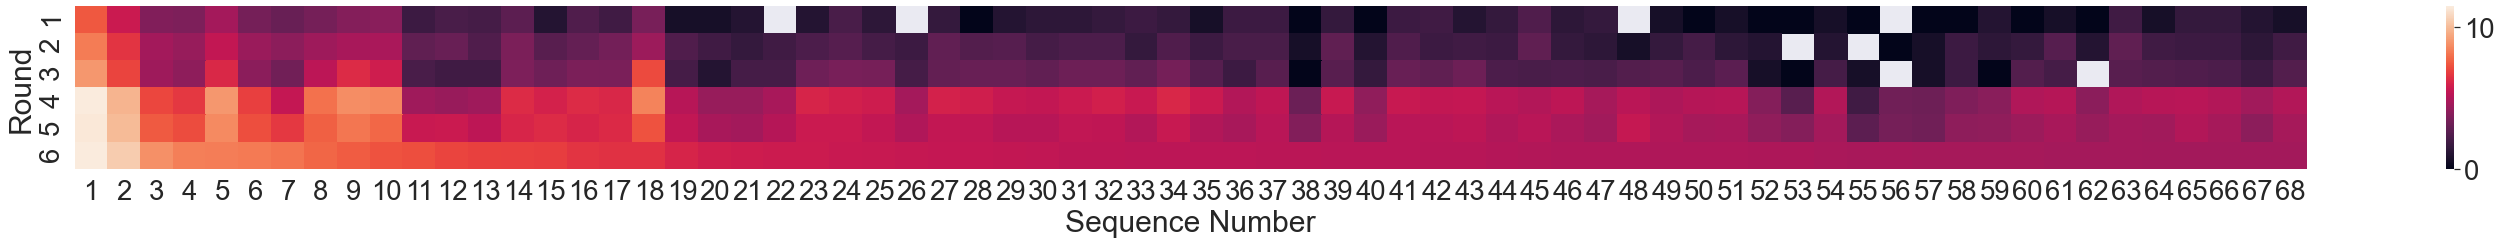

In [5]:
sns.set()
sns.set(font_scale = 2.5)
plt.figure(figsize=(50, 3))
all_cs3_log_counts_per_round_sorted = np.array(sorted(all_cs3_log_counts_per_round, key=lambda x:x[-1])[::-1]).T
hm = sns.heatmap(all_cs3_log_counts_per_round_sorted,  cbar=True, linecolor='black',xticklabels = range(1,1+len(all_cs3_log_counts_per_round_sorted[0])), vmin = 0, vmax = np.log(cs3_counts), yticklabels = range(1, 1+len(all_cs3_log_counts_per_round_sorted)))
plt.xlabel('Sequence Number')
plt.ylabel('Round')



In [6]:
def seqmatch(seq1, seq2):
    counter=0
    for pos in range(len(seq1)):
        if seq1[pos]!=seq2[pos]:
            counter+=1
    return counter

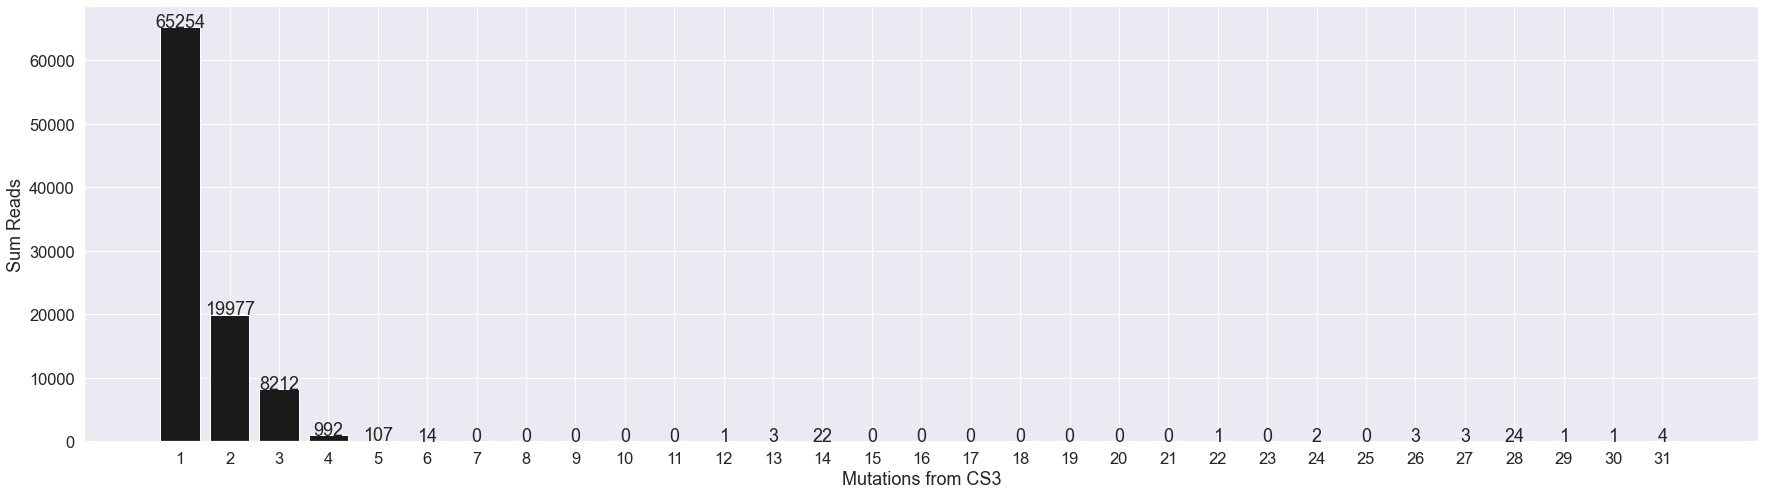

<ipython-input-7-aff64b328879>:48: RuntimeWarning: invalid value encountered in true_divide
  
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite 

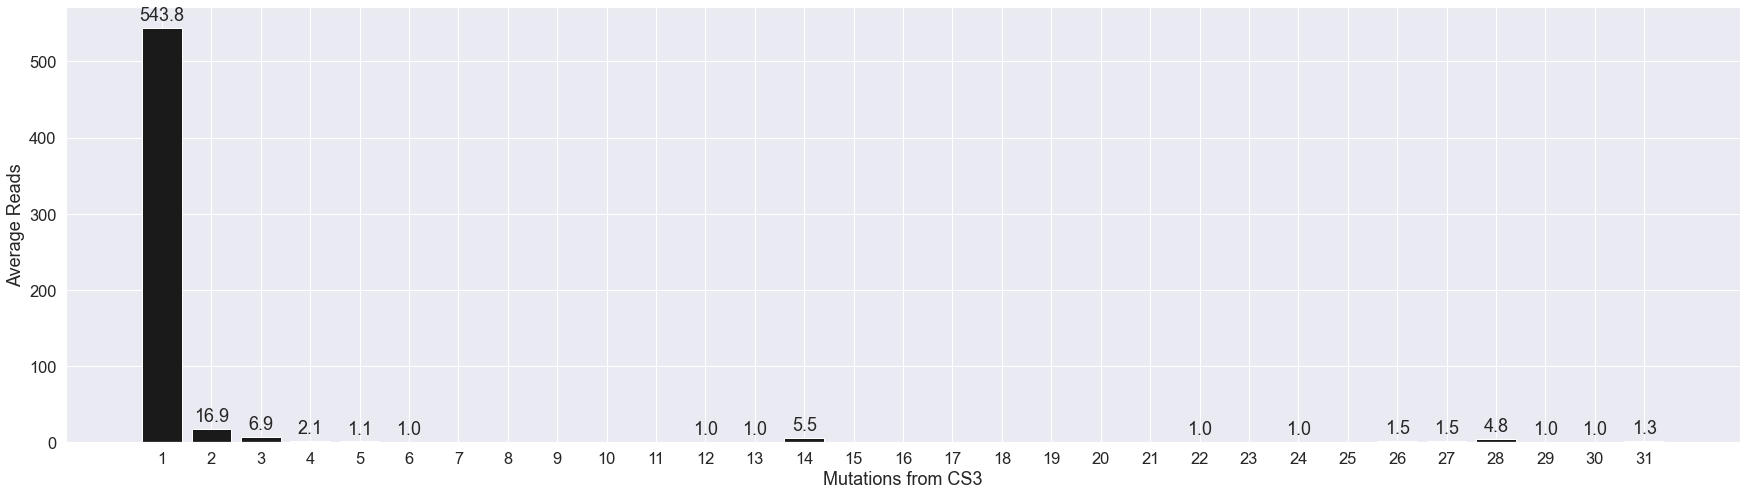

In [7]:
#PLOT OF CS3 seqs with # mutations from CS3 by reads
mutations_from_cs3 = []
max_muts = 0
for seq in clustering_spreadsheet:
    #If in cluster 3
    if seq.split(',')[-1].strip() == cs3_cluster_number:
        muts = seqmatch(cs3, seq.split(',')[0])
        if muts>max_muts:
            max_muts = muts
        mutations_from_cs3.append([muts, int(seq.split(',')[1])])
            
mut_num = 3
sum_by_mut = []
num_muts = []
for mut_num in range(max_muts+1):
    read_sum = 0
    num = 0
    for entry in mutations_from_cs3:
        if entry[0]==mut_num:
            read_sum+=entry[1]
            num+=1
    sum_by_mut.append(read_sum)
    num_muts.append(num)
    
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i+1,y[i]+10,y[i], ha = 'center')
        
plt.figure(figsize=(30, 8))

sum_by_mut = sum_by_mut[1:]
num_muts = num_muts[1:]

sns.set()
sns.set(font_scale = 1.5)
plt.bar(range(1, max_muts+1), sum_by_mut, color = 'k')
plt.xlabel('Mutations from CS3')
plt.ylabel('Sum Reads')
plt.xticks(range(1, max_muts+1))
addlabels(range(1, max_muts+1), sum_by_mut)

plt.show()

#PLOT OF CS3 seqs with # mutations from CS3 by AVG reads
plt.figure(figsize=(30, 8))

avg = (np.array(sum_by_mut)/np.array(num_muts)).round(1)
sns.set()
sns.set(font_scale = 1.5)
plt.bar(range(1, max_muts+1), avg, color = 'k')
plt.xlabel('Mutations from CS3')
plt.ylabel('Average Reads')
plt.xticks(range(1, max_muts+1))

addlabels(range(1, max_muts+1), avg)

plt.show()

In [8]:
#Mutation heatmap from all sequences
rs1 = 'GAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCT'

all_mutations = []
for round in range(len(all_trimmed_seqs)):
    mutations_from_rs1 = []
    for seq in all_trimmed_seqs[round]:
        mutations_from_rs1.append(seqmatch(seq, rs1))
    all_mutations.append({k: v for k, v in sorted(dict(Counter(mutations_from_rs1)).items(), key=lambda item: item[0])})

for round in range(len(all_mutations)):
    for value in list(range(40)):
        if value not in list(all_mutations[round].keys()):
            all_mutations[round][value] = 0


In [9]:
all_mutations_to_plot = []
for round in all_mutations:
    all_mutations_to_plot.append(list(round.values()))
    
seqs_per_round = []
for round in all_trimmed_seqs:
    seqs_per_round.append(len(round))
    

Text(196.5, 0.5, 'Round')

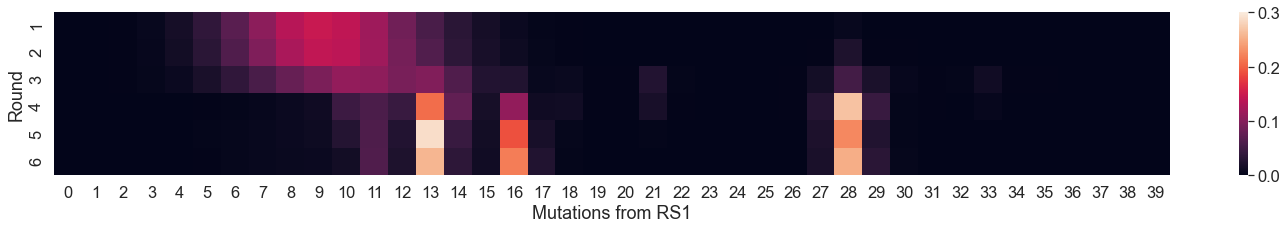

In [10]:
all_muts_scaled = []
max_muts = 0
for round in range(len(all_mutations_to_plot)):
    muts_scaled = []
    for mut in range(len(all_mutations_to_plot[round])):
        muts_scaled.append(all_mutations_to_plot[round][mut]/seqs_per_round[round])
    all_muts_scaled.append(muts_scaled)
    if max(muts_scaled)>max_muts:
        max_muts = max(muts_scaled)
all_muts_scaled = np.array(all_muts_scaled)

plt.figure(figsize=(25, 3))
sns.heatmap(all_muts_scaled,  cbar=True, linecolor='black',xticklabels = range(len(all_muts_scaled[0])), vmin = 0, vmax = 0.3, yticklabels = range(1, 1+len(all_muts_scaled)))
plt.xlabel('Mutations from RS1')
plt.ylabel('Round')



In [11]:
cs_new_clusters = ['GACAGCCGAGAAATGAGTGGCCTAAATGGGAGAATGAGCT','GACTGCGCGTATGAGTGGCGGCTAAAGAGGAGAATGAGCG','ACGGGTGGGTAATCTAGTGTCCGCGGAATAGAACGAAACA','GGATGGTGCGAACTGAGTGGGCTAATTAGGAGAATGAGCG','GGAGGGTGACATCGTTGAGAGAGAATGGGGATATTGAACT','AAGCTCTCGCCAGCAAAAGAACAGACCGTCGAGGAAACGG','CAATGCTATCCTCGGGGAACGATTCTGCGGAATCCGACAT','GAATCTGGCGAACGATTAGTCCTAATTGAGAATTATAGTT','AAGTGATGAATTCCCTGCGGGCTACTTGTTAGAGCGGGCT','GTGTGTTACGAACCGTGGCGACTAAGCGGGAGGGTGAACT'	]
distances_clusters = []
for seq in cs_new_clusters:
    distances_clusters.append(seqmatch(seq, rs1))



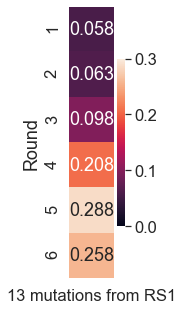

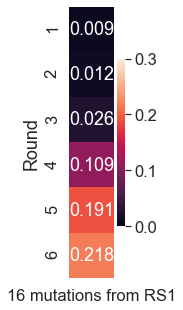

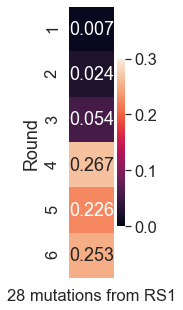

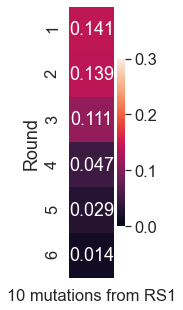

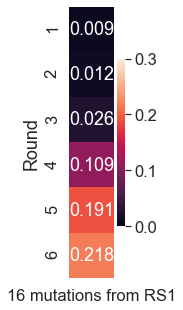

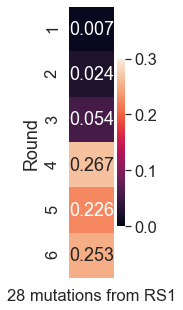

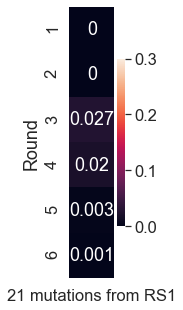

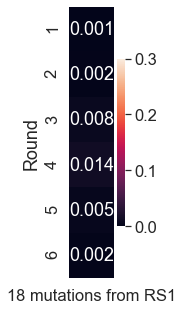

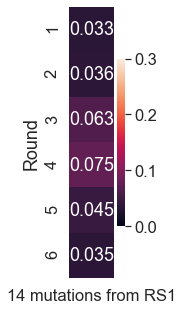

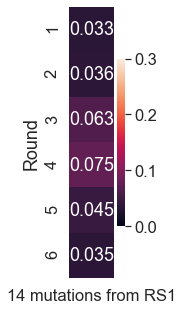

In [12]:
position = 13
for position in distances_clusters:
    subset = []
    for round in range(len(all_muts_scaled)):
        subset.append(all_muts_scaled[round][position])
    plt.figure(figsize=(1, 5))
    df = pd.DataFrame({str(position)+' mutations from RS1': np.array(subset).round(3)},
                      index=range(1,7))
    sns.heatmap(df, annot=True, fmt="g", vmin = 0, vmax = 0.3)
    plt.ylabel('Round')
    plt.show()

In [13]:
#CS3 Circle Plot

#GGACAGCGGAAUGCUGCCAACCGUGCGGGCUAAUUGGCAGACUGAGCUCGCUGUCC
#<<<<<<<<.....<<<<<<<.............>>>>>>>........>>>>>>>>

cs_rs1_variability = []
for position in range(len(rs1)):
    different = 0
    for seq in cs3_seqs:
        if seq[position]!=rs1[position]:
            different+=1
    cs_rs1_variability.append(different/len(cs3_seqs))
print('Circle Plot for CS3')
ribosketch = ([1]*8+cs_rs1_variability+[0]*8)
for element in ribosketch:
    print(str(element)+' ')


Circle Plot for CS3
1 
1 
1 
1 
1 
1 
1 
1 
0.9806638736706413 
0.9684176603287141 
0.9861424427972929 
0.9758298420883016 
0.02159200773445053 
0.9677731227844022 
0.9639058975185305 
0.30164357073799547 
0.9896873992910087 
0.9465033838221076 
0.03931679020302933 
0.039639058975185305 
0.9065420560747663 
0.03190460844344183 
0.9925878182404125 
0.9893651305188528 
0.06348694811472769 
0.8250080567193039 
0.06832097969706735 
0.9883983242023848 
0.9938768933290364 
0.17015791169835642 
0.9809861424427972 
0.9693844666451821 
0.9906542056074766 
0.9825974863035772 
0.9838865613922011 
0.9590718659361908 
0.9632613599742185 
0.9900096680631647 
0.9909764743796327 
0.9803416048984853 
0.03029326458266194 
0.03351595230422172 
0.9780857234933935 
0.9813084112149533 
0.10538188849500484 
0.9755075733161457 
0.02320335159523042 
0.9803416048984853 
0 
0 
0 
0 
0 
0 
0 
0 


In [18]:
#Circle Plots for each of the other clusters
for cluster in range(1,6):
    cs = cs_peaks[cluster-1]
    cs_cluster_number = 0
    cs_counts = 0
    for seq in clustering_spreadsheet:
        if cs in seq:
            cs_cluster_number = seq.split(',')[-1].strip()
            cs_counts = int(seq.split(',')[1].strip())
    cs_seqs = []       
    for seq in clustering_spreadsheet:
        #If in cluster 3
        if seq.split(',')[-1].strip() == cs_cluster_number:
            cs_seqs.append(seq.split(',')[0])

    cs_rs1_variability = []
    for position in range(len(rs1)):
        different = 0
        for seq in cs_seqs:
            if seq[position]!=rs1[position]:
                different+=1
        cs_rs1_variability.append(different/len(cs_seqs))
    print('Circle Plot for CS'+str(cluster))
    ribosketch = ([0]*8+cs_rs1_variability+[0]*8)
    for element in ribosketch:
        print(str(element)+' ')
    
    print(',,,,')
    i = 1
    for element in ribosketch:
        print(str(i)+'\t'+str(np.array(element).round(2))+' ')
        i+=1

Circle Plot for CS1
0 
0 
0 
0 
0 
0 
0 
0 
0.025789346830561583 
0.11641359363702097 
0.8852735598939504 
0.9127500602554832 
0.028681610026512414 
0.2205350686912509 
0.8782839238370692 
0.030850807423475537 
0.8604483007953724 
0.9129910821884791 
0.052060737527114966 
0.09351651000241022 
0.6430465172330682 
0.9621595565196432 
0.05061460592913955 
0.9445649554109424 
0.020486864304651724 
0.9657748855145818 
0.03012774162448783 
0.026994456495541094 
0.935406121957098 
0.056158110388045315 
0.0636297903109183 
0.0636297903109183 
0.08724993974451675 
0.5449505905037358 
0.1009881899252832 
0.07495782116172572 
0.029163653892504218 
0.9742106531694384 
0.058327307785008435 
0.021691973969631236 
0.04844540853217643 
0.9395034948180284 
0.03470715835140998 
0.04796336466618462 
0.11641359363702097 
0.05350686912509038 
0.1369004579416727 
0.2031814895155459 
0 
0 
0 
0 
0 
0 
0 
0 
,,,,
1	0 
2	0 
3	0 
4	0 
5	0 
6	0 
7	0 
8	0 
9	0.03 
10	0.12 
11	0.89 
12	0.91 
13	0.03 
14	0.22 
15	0

In [15]:
#Pretty Landscpe Fig

all_tracking = []
for cs in cs_peaks:
    tracking = []
    for round in range(len(all_trimmed_seqs)):
        tracking.append(all_trimmed_seqs[round].count(cs))
    tracking = np.array(tracking)/len(all_trimmed_seqs[round])
    all_tracking.append(tracking)

Text(0, 0.5, 'Abundance')

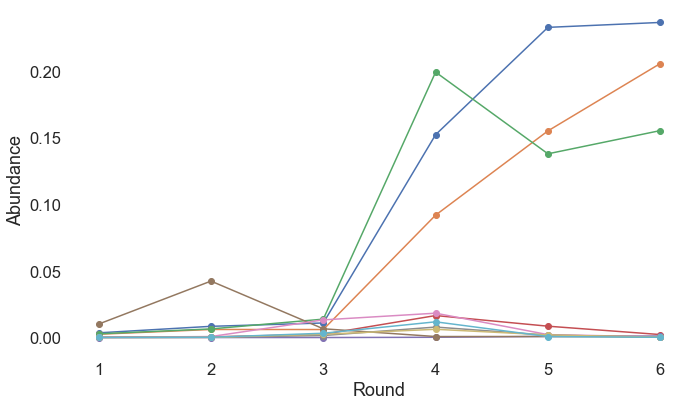

In [16]:
f, ax = plt.subplots(figsize=(10,6), tight_layout=True)

plt.rc('grid', linestyle="-", color='lightgray')
plt.grid(True)

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

i=0
for seq in all_tracking:
    plt.plot(range(1,7), seq, marker = 'o')
    i+=1

ax.set_facecolor('white')
#plt.axhline(0, color='black', linewidth=1)
#plt.axvline(0, color='black', linewidth=1)

plt.xlabel('Round')
plt.ylabel('Abundance')